In [1]:
#loading libraries
import numpy as np
import scipy as sp
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import bokeh.plotting

# For interfacing with the file system
import glob
import subprocess
import os
import time

import importlib
import bilge_pype as bpy

In [2]:
importlib.reload(bpy)
bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:
# load fastq data
fastq_folder = 'fastq'
files = glob.glob(fastq_folder+'/*.fastq')
reads = bpy.load_basecalled_data(files)
print('Appending time data')
reads['time (hrs)'] = reads['datetime']-np.min(reads['datetime'])
reads['time (hrs)'] = reads['time (hrs)'].values.astype(float)/60/60/1e9
reads = reads.drop(columns = ['sequence'])
primers = bpy.load_primers('primers.csv')

Processing 0/92, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_0.fastq
elapse = 0.20s
Processing 20/92, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_20.fastq
elapse = 3.62s
Processing 40/92, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_40.fastq
elapse = 6.95s
Processing 60/92, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_60.fastq
elapse = 10.10s
Processing 80/92, current file = fastq/fastq_runid_477fdb09921842662b221840eee0fbc8d6530bea_80.fastq
elapse = 13.36s
Appending time data
Reading primers from  primers.csv


In [5]:
files = glob.glob('./frags/fraginfo_*.csv.gz')
out = []
for i in files:
    out.append(pd.read_csv(i))
frags = pd.concat(out)
frags = bpy.remove_overlaps(frags, metric = 'AS', thresh = 50)
frags = frags.sort_values(by=['query_id','q_start'])

filtering to best aligned fragments
Cleaned out 1500659 of 2828644


In [6]:
# compute unmapped reads
def annotate_unmapped(reads, frags):
    ureads = [i for i in set(reads['id']) - set(frags['query_id'])]
    mreads = np.unique(frags['query_id'])
    ureads = pd.DataFrame(ureads, columns = ['id'])
    mreads = pd.DataFrame(mreads, columns = ['id'])
    ureads['pseudo_mapped'] = False
    mreads['pseudo_mapped'] = True
    ureads = pd.concat([ureads,mreads])
    
    # replace the existing pseudo_mapped column if it exists
    if 'pseudo_mapped' in reads.columns:
        reads = reads.drop(columns = ['pseudo_mapped'])
    reads = reads.merge(ureads, on = 'id', how = 'left')
    return reads

reads = annotate_unmapped(reads, frags)

In [7]:
print('Loading species data')
# load species info
species_file = './species_info/Nanopore_ref_db_all_runs_info.csv'
run_info = 'Nanopore_run_02Feb19'
#run_info = 'Nanopore_run_15May19'
df_species = pd.read_csv(species_file)
df_species = df_species[df_species[run_info]=='T'] # only load runs used in current experiment

print('Loading consensus sequence data')
df_cons = pd.read_csv('cons.csv.gz')
print('Loading accuracy data')
df_acc = pd.read_csv('acc.csv.gz')
df_acc = df_acc.rename(columns={'query_id':'id','database_id':'HapID'})
print('Loading primer match info')
df_pmatch = pd.read_csv('primer_match.csv.gz')
df_pmatch['perror'] = 1-(df_pmatch['fwd_match']+df_pmatch['rev_match'])/(df_pmatch['fwd_tot']+df_pmatch['rev_tot'])
print('Merging data')
df_acc = df_acc.merge(df_pmatch[['id','fwd_primer','rev_primer','perror']], on = 'id', how = 'left')
df_acc = df_acc.merge(df_cons[['id','N frags','consensus']], on = 'id', how = 'left')

Loading species data
Loading consensus sequence data
Loading accuracy data
Loading primer match info


/home/bilgenurb/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Merging data


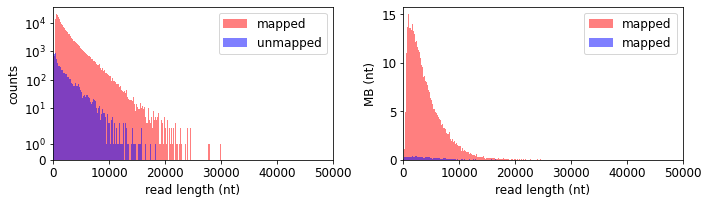

total reads =  352830
pseudo_ref unmapped reads =  12148
total reads(Gb) =  0.720329238
pseudo_ref unmapped reads (Gb) =  0.02056794
Number of mapped consensus sequences =  270400
Number of unmapped consensus sequences =  1666


In [8]:
# print the distribution of read lengths
def plot_length_dist(ax, df, color = 'red', alpha = 0.5, label = '', by_counts = True):
    if by_counts:
        plt.hist(df['length'], bins = np.arange(0,50e3,100),
                 alpha = alpha, color = color, label = label)
        plt.ylabel('counts')
        plt.yscale('symlog')
    else:
        plt.hist(df['length'], bins = np.arange(0,50e3,100),
                 weights = df['length']/1e6, alpha = alpha, color = color, label = label)
        plt.ylabel('MB (nt)')
    plt.xlabel('read length (nt)')
    plt.xlim([0,50e3])
    
plt.figure(1, figsize=(10,3))
plt.rcParams.update({'font.size': 12})

plt.subplot(1,2,1)
plot_length_dist(plt.gca(), reads[reads['pseudo_mapped']==True], color = 'red',
                 label = 'mapped')
plot_length_dist(plt.gca(), reads[reads['pseudo_mapped']==False], color = 'blue',
                 label = 'unmapped')
plt.legend()

plt.subplot(1,2,2)
plot_length_dist(plt.gca(), reads[reads['pseudo_mapped']==True], color = 'red',
                 label = 'mapped', by_counts = False)
plot_length_dist(plt.gca(), reads[reads['pseudo_mapped']==False], color = 'blue',
                 label = 'mapped', by_counts = False)
plt.tight_layout()
plt.legend()
plt.show()

tot_reads = len(reads)
tot_readgb = np.sum(reads['length'])/1e9
unmapped = np.sum(reads['pseudo_mapped']==False)
unmapped_gb = np.sum(reads[reads['pseudo_mapped']== False]['length'])/1e9

print('total reads = ', tot_reads)
print('pseudo_ref unmapped reads = ', unmapped)
print('total reads(Gb) = ', tot_readgb)
print('pseudo_ref unmapped reads (Gb) = ', unmapped_gb)
print('Number of mapped consensus sequences = ', len(df_acc['HapID']))
print('Number of unmapped consensus sequences = ', len(df_cons)-len(df_acc['HapID']))

# Make a pie chart

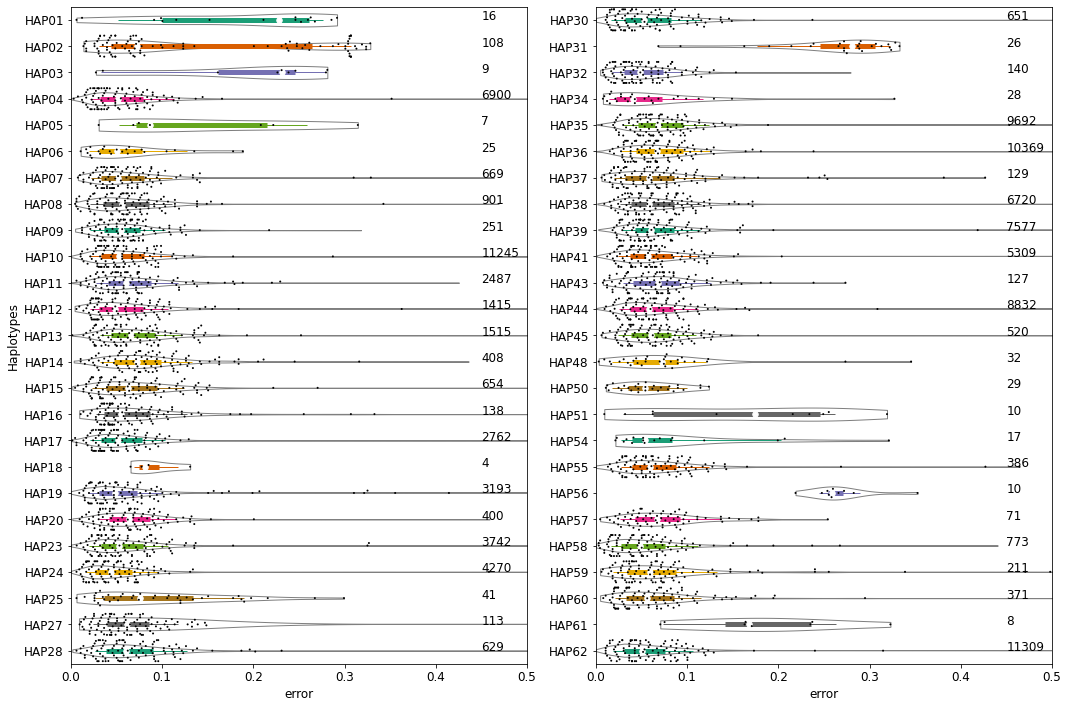

In [9]:
haps = []
for s in np.unique(df_acc['HapID'].values):
#for s in df_species['HapID_Bilge']:
    if s[:3] == 'HAP':
    #if s[:5] == 'M-OTU':
        haps.append(s)

data = df_acc[df_acc['HapID'].isin(haps)]
data = data.sort_values(by = ['HapID'])
data['error'] = 1-data['score']
c = data['fwd_primer'].notna() & data['rev_primer'].notna()
data = data[c]

# subsample to data to make swarmplot work
df_sub = bpy.stats_subsample(data, col = 'HapID', N = 100)
# split into subplots swarm plot don't look crowded
slist = np.array_split(np.unique(df_sub['HapID']),2)

fig = plt.figure(1, figsize = (15,10))
for i in range(0, len(slist)):
    plt.subplot(1,2,i+1)
    d = data[data['HapID'].isin(slist[i])]
    bpy.mpl_box_whisker(plt.gca(), d[['HapID','error']], text_y = 0.45, counts = True,
                        cmap = plt.cm.get_cmap('Dark2').colors)
    bpy.mpl_violin(plt.gca(), d[['HapID','error']], face_color='white', edge_color='black')
    d = df_sub[df_sub['HapID'].isin(slist[i])]
    sns.swarmplot(x = 'error', y = 'HapID', data = d, alpha = 1, color = 'Black', s = 2)
    if i == 0:
        plt.ylabel('Haplotypes')
    else:
        plt.ylabel('')
    plt.xlim([0,0.5])
plt.tight_layout()
plt.show()

In [10]:
data = df_acc
data = data.sort_values(by = ['HapID'])
data['error'] = (1-data['score'])
c = data['fwd_primer'].notna() & data['rev_primer'].notna()
data = data[c]

x = data['N frags']
y = data['error']

In [11]:
c = (df_acc['N frags']>1) & df_acc['fwd_primer'].notna() & df_acc['rev_primer'].notna()
x = df_acc[c].sort_values(by = ['score'])
x

,id,q_len,q_start,q_end,orientation,HapID,t_len,t_start,t_end,match,...,rl,CIGAR,match_score,similarity,score,fwd_primer,rev_primer,perror,N frags,consensus
18403,115f2458-61a7-49df-885e-4e8b3aaa39af,274,44,196,-,HAP41,648,0,648,145,...,0,61M2D7M85D12M400D1M1D26M7D10M1D35M,0.223765,0.529197,-0.835766,HCO_C2,LCO_C2,0.081081,2,TGGCTCGGGTGTCTCAATGATGGAGAGACACAAACTCTAGGTGACC...
169209,a0191924-94a3-4ee4-a4cc-2c0ada491c25,283,63,229,-,HAP19,658,0,654,158,...,0,31M1D10M2I9M2D17M1I5M1I7M1I3M1D7M485D44M1D17M3...,0.239757,0.558304,-0.770318,HCO_C2,LCO_C2,0.036697,2,GTGGCTCAGAGTGTCTCAATGATGGAGATTACTGTAACTTCAGGGT...
255676,f221f2bd-3d80-4afa-83e1-45d0b54c6ff0,286,46,203,-,HAP41,648,1,645,150,...,0,25M1D5M1I23M2I14M1D6M1D9M484D13M2D16M1D18M1D17...,0.231481,0.524476,-0.741259,HCO_C2,LCO_C2,0.028846,2,GCTCAGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGTGACC...
37119,2362d428-9422-44c8-93e5-6b8043a5e573,285,55,199,-,HAP27,633,0,625,134,...,0,5M1D16M1I50M484D37M1I13M1D4M3I14M,0.212698,0.470175,-0.740351,HCO_C2,LCO_C2,0.067308,2,TGGCTCAGGTGTCTCAATGATGGAATTACTGTAAACTTCAGAATTG...
103105,61814415-8a73-43b9-b91e-2074927b731e,285,49,193,-,HAP27,633,0,633,143,...,0,47M1D19M483D16M3D3M2D59M,0.225908,0.501754,-0.719298,HCO_C2,LCO_C2,0.008929,8,TGGCTCGGGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGGT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32205,1eb7bb3b-512a-489d-af47-cac3d02b0df4,1015,833,874,-,HAP17,658,617,658,41,...,8,41M,1.000000,0.062310,1.000000,HCO_C2,LCO_C2,0.009615,4,GATGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGG...
31770,1e4822ab-26f1-499d-a634-410dc457dcb1,976,855,895,+,M-OTU112,421,160,200,40,...,0,40M,1.000000,0.095012,1.000000,HCO_C2,LCO_C2,0.000000,6,AATGATGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTTCA...
61906,3a95e77b-61f6-4910-952d-1f24bc61818e,1135,77,126,+,HAP23,658,68,117,49,...,8,49M,1.000000,0.074468,1.000000,HCO_C2,LCO_C2,0.019048,6,TTTCGGTAGCCTTTGGTTTCGGTTACGTATTGCTGGCGTCTGCTTG...
75156,473dcccf-2539-478b-8207-92529d173e40,784,59,717,-,HAP04,658,0,658,658,...,27,658M,1.000000,1.000000,1.000000,HCO_C2,LCO_C2,0.000000,15,GTGGCTCGGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGGT...


In [12]:
i = 2
rid = x.iloc[i]['id']
print(x.iloc[i].values)
print(frags[frags['query_id']==rid])
print(reads[reads['id']==rid].values)

['f221f2bd-3d80-4afa-83e1-45d0b54c6ff0' 286 46 203 '-' 'HAP41' 648 1 645
 150 648 13 'P' 83 88 51 498 -278 116 0 0
 '25M1D5M1I23M2I14M1D6M1D9M484D13M2D16M1D18M1D17M1I7M' 0.2314814814814815
 0.5244755244755245 -0.7412587412587412 'HCO_C2' 'LCO_C2'
 0.028846153846153855 2
 'GCTCAGGTGTCTCAATGATGGAGATTACTGTAAACTTCAGGTGACCAAAAATCCAGAATAAGTGTTGATAAGAATAGGGTCTCCTCCTCTGCTGGATCAAAGAAAAGTATTTAAATTTGGTCATCATAATTAAGCACCGGGATGACCCATAATTCAACACGGATTAAGATATATAAGGAGGTACCTACTATTCCGGCTCAAGCCCCGAAGATAAGTATAATGTTCCAATAATGTCTTTATGATTTGTTGACCGTTCACCGCGTAACTACCAAGTAATACCACGATG']
                                     query_id  q_len  q_start  q_end  \
2088586  f221f2bd-3d80-4afa-83e1-45d0b54c6ff0    499       80    250   
2088581  f221f2bd-3d80-4afa-83e1-45d0b54c6ff0    499      260    428   

        orientation                                     database_id  t_len  \
2088586           +                                       cluster38    756   
2088581           +  a8726b90-1421-4843-bd93-8ec3b20165e4_rs130_8

In [13]:
df_species[df_species['HapID_Bilge']=='HAP55'].values

array([['CACTTTATATTTTATTTTTGGGATTTGATCAGGCCTAATTGGATCATCTTTAAGATTTATTATCCGAATAGAACTGAGAACCCCAGGCAGATTTATTGGAAACGATCAAATTTATAATGTAATTGTAACATCACACGCATTTATTATAATTTTTTTTATAGTTATACCTATTATAATTGGTGGATTCGGAAATTGATTAGTTCCTTTAATATTGGGGTCGCCTGATATAGCCTTTCCTCGTATAAATAATTTAAGATTTTGATTTCTTCCCCCCTCTTTAATTTTTCTTTTATTAAGAAGACTATCAAACTCAGGAGCTGGAACCGGCTGAACAGTCTACCCTCCCCTCTCTTCAAATCTATCCCACACAGGAAGATCTGTGGATTTAACTATTTTTTCCCTGCATATAGCCGGAATTTCATCAATCCTGGGAGCTATTAATTTTATCTCAACTATTATAAATATAAAATTTAAAAATTTAAATTATGAAATGATTCCCTTATTTGTATGATCTATCTTAATTACAGCAGTTCTTTTACTTTTATCACTCCCCGTTTTAGCAGGAGCTATTACTATACTATTAACTGATCGAAATTTAAATACTTCTTTTTTTGACCCAGCAGGGGGGGGGGATCCCATTCTTTATCAACATTTATTT',
        'Hydropsyche dinarica', 'BIOUG43946-A04', 'HAP55', 'Bilge', 'T',
        'T', 'T', 'F', 'F']], dtype=object)

In [14]:
def select_haps(df, haps):
    out = []
    for i in haps:
        d = df[df['HapID']==i]
        N = 1000
        if len(d) > N:
            ridx = np.random.permutation(len(d))
            out.append(d.iloc[ridx[:N]])
        else:
            out.append(d)
    return pd.concat(out)

# get only items with fwd and rev primer
s = (df_acc['fwd_primer']=='HCO_C2') & (df_acc['rev_primer']=='LCO_C2')
L = ['HAP07','HAP08','HAP09','HAP60']
df_q = select_haps(df_acc[s], L)
df_q = df_q.rename(columns = {'consensus':'sequence'})
df_q = df_q.merge(df_cons[['id','msa_input_file']], on = 'id', how = 'left')

In [15]:
L = []
for i in range(0,len(df_species)):
    if df_species.iloc[i]['HapID_Bilge'][:3] == 'HAP':
        L.append(i)
df_d = df_species.iloc[L].rename(columns = {'Hap_Sequence':'sequence', 'HapID_Bilge':'id'})
df_d = df_d[['id', 'sequence']]
df_q2 = df_cons.rename(columns = {'consensus':'sequence'})

In [4]:
!pwd

/home/bilgenurb/NanoporeRCA/runs/20190917BB_guppy


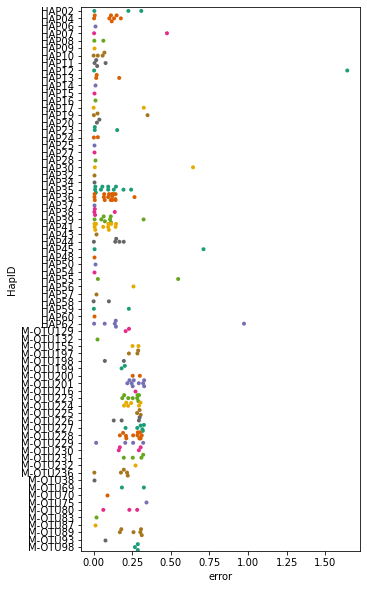

In [3]:
acc_ps = pd.read_csv('acc_ps.csv.gz')
acc_ps = acc_ps[acc_ps['q_len'] > 0]
#df = pd.read_csv('clusters.csv.gz')
#df = df.rename(columns = {'id':'query_id'})
#acc_ps = acc_ps.merge(df, on = 'query_id', how = 'left')
acc_ps = acc_ps.rename(columns = {'database_id':'HapID','query_id':'id'})

plt.figure(1, figsize=(5,10))
slist = np.unique(acc_ps['HapID'])
acc_ps['error'] = 1-acc_ps['score']
acc_ps = acc_ps.sort_values(by = ['HapID'])
d = bpy.stats_subsample(acc_ps, col = 'HapID', N = 20)
lines = sns.swarmplot(x = 'error', y = 'HapID', data = d, alpha = 1, palette = 'Dark2', s = 4)

In [18]:
files = glob.glob('pseudodb.csv.gz.*')
for i in range(0,len(files)):
    subprocess.call(['./get_accuracy.py','-i',files[i],'-o','acc_ps.csv.gz.'+str(i)])

In [19]:
files2=glob.glob('acc_ps.csv.gz.*')
for i in range(0,len(files2)):
    f=pd.read_csv(files2[i])
    print(files2[i], len(np.unique(f['database_id'])), len(f))

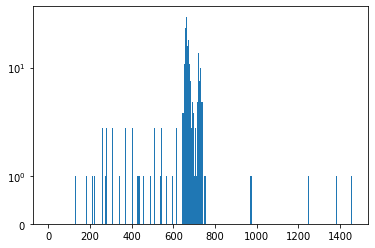

In [4]:
plt.hist(acc_ps['q_len'], bins = np.arange(0,np.max(acc_ps['q_len'])+10,5))
plt.yscale('symlog')
plt.show()

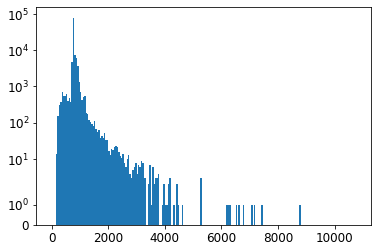

In [32]:
c = df_acc['fwd_primer'].notna() & df_acc['rev_primer'].notna()
plt.hist(df_acc[c]['q_len'], bins = np.arange(0,np.max(df_acc['q_len'])+10,50))
plt.yscale('symlog')
plt.show()

In [5]:
importlib.reload(bpy)

data = pd.read_csv('pseudodb.csv.gz.0')
files = bpy.get_pairwise_distance(data, block = 500, output_folder = './pwout/', workspace = './pw_aligner/',
                                  config = '-k15 -w10 -p 0.9 -D', symmetric = True)
tmp = []
for f in files:
    tmp.append(pd.read_csv(f))
bpy.batch_file_remove(files)
tmp = pd.concat(tmp)
fout = 'pw_data.csv.gz'
tmp.to_csv(fout, index = False)
pw = pd.read_csv(fout)
metric = 'match_score'
dct = np.unique(data['id'])
dct = {dct[i]:i for i in range(0,len(dct))}
pw = bpy.get_best(pw, ['query_id','database_id'], metric)
pw = bpy.get_feature_vector(pw[['query_id','database_id',metric]], symmetric = True, d_dct=dct, q_dct=dct)
pw = bpy.get_symmetric_matrix(pw, sym_larger = False)

processing block 0,0 0/6.0
processing block 0,1 1/6.0
processing block 0,2 2/6.0
processing block 1,1 3/6.0
processing block 1,2 4/6.0
processing block 2,2 5/6.0


In [6]:
importlib.reload(bpy)

col = pw.columns[pw.columns!='id']
x = pw[pw['id'].isin(col)]
rid = x['id'].values
x = x[col].values
for i in range(0,len(col)):
    x[i,i] = 1
z = bpy.dist_cosine(x,x)
y = pd.DataFrame(1-x, columns = col)
y['id'] = rid

In [14]:
df_clst = bpy.cluster_hierarchical(y, metric = 'precomputed', linkage = 'complete',thresh = 0.5)
N_uc = np.sum(df_clst['cluster_id']==-1)
N_cl = len(np.unique(df_clst['cluster_id']))-1
N_dt = len(df_clst) - N_uc - N_cl
print(N_uc, N_cl, N_dt)
#df = acc_ps.merge(df_clst, on = 'id', how = 'left')
#df = df[['id','NM','q_len','HapID','cluster_id']]
#df.sort_values(by = ['HapID','cluster_id','NM']).to_csv('hcl.csv', index=False)

Running hierarchical clustering
238 409 588


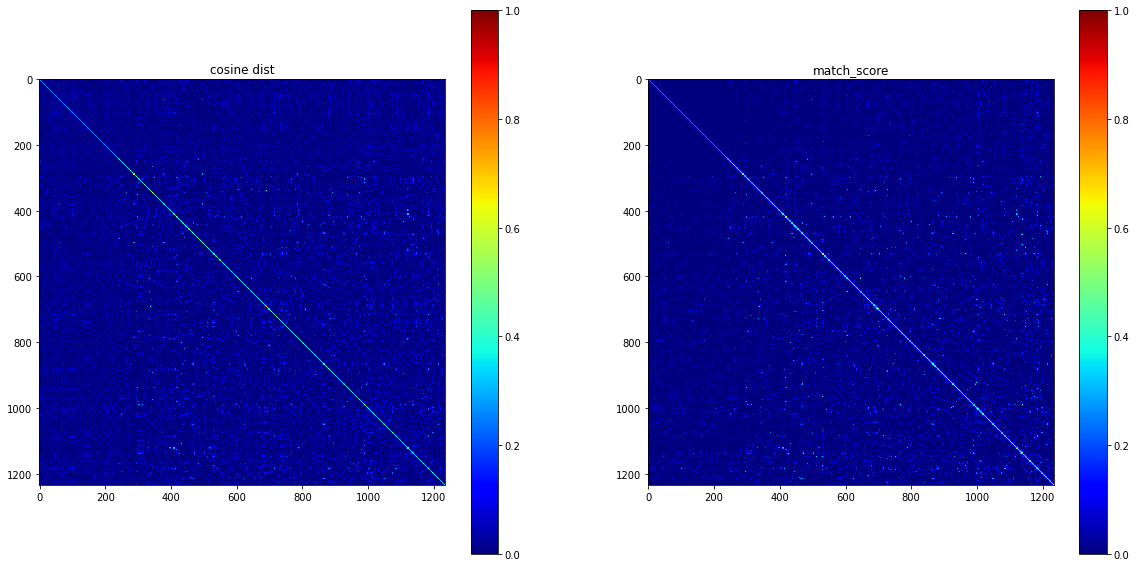

In [15]:
if True:
    n = df_clst['cluster_id']
    s = np.argsort(n)
    x2 = x[s]
    x2 = x2.T[s]
    z2 = z[s]
    z2 = z2.T[s]

plt.figure(1, figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(1-z2, cmap = 'jet')
plt.title('cosine dist')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(x2, cmap = 'jet')
plt.title('match_score')
plt.colorbar()

plt.show()

In [13]:
importlib.reload(bpy)
df_centers = pd.read_csv('rcent_2_2020_03_21_23_26_19_c58.csv.gz')
data, df_vec, df_align = bpy.cluster_metric(df_q2, df_centers, config = '-k15 -w10 -p 0.9 -D')

FileNotFoundError: [Errno 2] No such file or directory: 'rcent_2_2020_03_21_23_26_19_c58.csv.gz'

Running hierarchical clustering


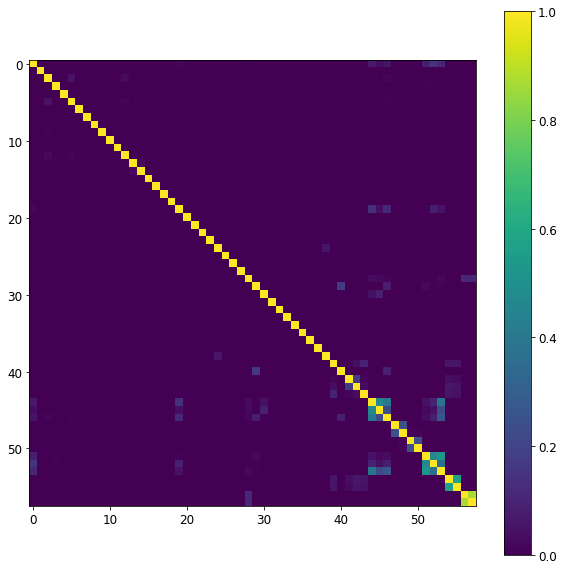

In [99]:
col = ['id']+['cosim_'+i for i in data['id']]
df_clst = bpy.cluster_hierarchical(data[col], metric = 'precomputed', linkage = 'complete',
                                   thresh = 0.8)
col = ['cosim_'+i for i in data['id']]
x = data[col].values
if True:
    n = df_clst['cluster_id']
    s = np.argsort(n)
    x = x[s]
    x = x.T[s]
plt.figure(1, figsize = (10,10))
plt.imshow(1-x)
plt.colorbar()
plt.show()

In [12]:
acc_ps = pd.read_csv('acc_ps.csv')
acc_ps = acc_ps.rename(columns = {'query_id':'id'})
df_clst = df_clst.merge(acc_ps, on = 'id', how = 'left')

In [13]:
seq = pd.read_csv('clusters.csv.gz')
print(seq[seq['id'] == 'cluster12'].values)
print(seq[seq['id'] == 'cluster13'].values)
print(seq[seq['id'] == 'cluster75'].values)


[['cluster12'
  'AAATAGGTGTTGGTATAAAATTGGGTCTCCCCTCCAGCTGGGTCAAAGAAAGAAGTATTTAAGTTACGATCTGTTAATAATATTGTAATTGCCCCTGCTAAGACGGGTAAAGACAGTAGTAATAAAATAGCTGTAATCACTACTGACCAAACAAATAGCGGGATTCGGTCTATTGTTATTCCTCTTGATCGTATATTAATTGTAGTTGTAATAAAGTTTACAGCTCCTAAGATTGAGGAAATTCCTGCCAAATGAAGGGAGAAAATAGCGAGGTCCACTGAAGCTCCGGCATGGGCGATTCCAGCTGCGAGGGGTGGGTAAACCGTTCATCCTGTCCCAGCCCCGTTTTCCACTAGGCTTCTAGTCAATAGGAGTGTTAAAGCAGGGGGTAAAAGTCAAAAGCTTATATTATTTATTCGAGGAAAGGCCATGTCGGGAGCCCCTAGTATAAGAGGGACCAGCCAGTTACCAAACCCACCAATTATAATAGGCATAACCATGAAAAAAATTATAATGAAAGCATGAGCAGTAACAATCACATTGTAAACTTGGTCGTCTCCAATTAAAGATCCTGGGTGTCCTAATTCAGCACGAATCAATAAACTAAGGGAGGTTCCTAATATTCCTGATCAAACTCCAAAAATAAAATATAAAGTT'
  False]]
[['cluster13'
  'AGAACCAAAATAGGTGTTGGTATAAAATTGGGTCTCCCCCTCCAGCTGGGTCAAAGAAAAGTATTTAAGTTACGATCTGTTAATAATATTGTAATTGCCCTGCTAAGACGGGTAAAGACAGTAGTAATAAAATAGCTGTAATCACTACTGACCAAACAAATAGCGGGATTCGGTCTATTGTTATTCCTCTTGATCGTATATTAATTGTAGTTGTAATAAAGTTTACAGCTCCTAAGATTGAGAAATTCCTGCCAAATGAAGGAGAAAATAGCGAGGTCCACTGAAGCTCCGGCATAG

In [14]:
df_clst = df_clst.sort_values(by = ['cluster_id','database_id'])
df_clst[['id','cluster_id','database_id','match_score']].values

array([['cluster107', -1, 'HAP02', 0.6931464174454829],
       ['cluster83', -1, 'HAP02', 0.7568],
       ['cluster98', -1, 'HAP02', 0.9967585089141004],
       ['cluster4', -1, 'HAP04', 0.9984802431610942],
       ['cluster57', -1, 'HAP04', 0.9803921568627452],
       ['cluster138', -1, 'HAP06', 0.9924012158054712],
       ['cluster120', -1, 'HAP07', 0.9954476479514416],
       ['cluster97', -1, 'HAP08', 0.9954407294832828],
       ['cluster129', -1, 'HAP09', 0.9954407294832828],
       ['cluster78', -1, 'HAP10', 0.9845440494590416],
       ['cluster116', -1, 'HAP11', 0.9848024316109424],
       ['cluster117', -1, 'HAP11', 0.9681335356600912],
       ['cluster118', -1, 'HAP11', 0.9286798179059179],
       ['cluster77', -1, 'HAP12', 0.9969604863221884],
       ['cluster76', -1, 'HAP13', 0.9864457831325302],
       ['cluster84', -1, 'HAP13', 0.7433414043583535],
       ['cluster123', -1, 'HAP14', 0.9908952959028832],
       ['cluster112', -1, 'HAP15', 1.0],
       ['cluster134', -1, 'HA